In [1]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm -rf /content/kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images -p /content/zip

Dataset URL: https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images
License(s): copyright-authors
100% 1.85G/1.85G [00:22<00:00, 47.4MB/s]
100% 1.85G/1.85G [00:22<00:00, 88.7MB/s]


In [5]:
!mkdir -p /content/mushrooms
!unzip -q /content/zip/mushrooms-classification-common-genuss-images.zip -d /content/mushrooms/
!rm -rf /content/mushrooms/mushrooms
!mv /content/mushrooms/Mushrooms/* /content/mushrooms/
!rm -rf /content/zip

In [6]:
!rm -rf /content/mushrooms/Mushrooms

In [7]:
import numpy as np
import pandas as pd
import torch

In [8]:
from PIL import Image
from collections import Counter
import os

size_counts = Counter()

# Обход всех файлов в директории
for root, _, files in os.walk('/content/mushrooms'):
    for file in files:
        file_path = os.path.join(root, file)
        with Image.open(file_path) as img:
            size = img.size  # Возвращает кортеж (ширина, высота)
            size_counts[size] += 1

# Вывод результатов
for size, count in size_counts.items():
    print(f"Размер {size[0]}x{size[1]}: {count} изображений")

Размер 800x600: 1450 изображений
Размер 800x533: 459 изображений
Размер 800x525: 40 изображений
Размер 750x492: 2 изображений
Размер 749x600: 4 изображений
Размер 700x533: 1 изображений
Размер 800x561: 7 изображений
Размер 800x532: 100 изображений
Размер 800x548: 25 изображений
Размер 700x411: 1 изображений
Размер 575x600: 1 изображений
Размер 800x536: 228 изображений
Размер 700x507: 2 изображений
Размер 800x439: 2 изображений
Размер 800x515: 8 изображений
Размер 800x496: 3 изображений
Размер 800x542: 16 изображений
Размер 800x606: 8 изображений
Размер 800x520: 8 изображений
Размер 780x585: 27 изображений
Размер 800x529: 13 изображений
Размер 800x541: 20 изображений
Размер 800x547: 15 изображений
Размер 800x595: 10 изображений
Размер 800x545: 22 изображений
Размер 800x669: 3 изображений
Размер 800x586: 8 изображений
Размер 800x526: 27 изображений
Размер 800x578: 11 изображений
Размер 800x531: 200 изображений
Размер 800x527: 25 изображений
Размер 800x632: 6 изображений
Размер 800x625: 3

In [9]:
print(min([size[0] for size in size_counts.keys()]))
print(min([size[1] for size in size_counts.keys()]))

259
152


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from PIL import ImageFile
import torch

ImageFile.LOAD_TRUNCATED_IMAGES = True

generator = torch.Generator().manual_seed(42)
np.random.seed(42)

base_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder('/content/mushrooms', transform=base_transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size], generator=generator)

# Применение трансформаций
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print(f"Количество изображений в полном датасете: {len(full_dataset)}")
print(f"Количество изображений в тренировочном после оверсэмплинга: {len(train_dataset)}")
print(f"Классы: {full_dataset.classes}")

Количество изображений в полном датасете: 6714
Количество изображений в тренировочном после оверсэмплинга: 5371
Классы: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=9):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            #1st layer
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=2),
            nn.BatchNorm2d(96),  # ДОБАВИЛИ
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #2nd layer
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),  # ДОБАВИЛИ
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #3rd layer
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),  # ДОБАВИЛИ
            nn.ReLU(inplace=True),
            #4th layer
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),  # ДОБАВИЛИ
            nn.ReLU(inplace=True),
            #5th layer
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # ДОБАВИЛИ
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            #6th layer
            nn.Dropout(p=0.6),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            #7th layer
            nn.Dropout(p=0.6),
            nn.Linear(4096, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0.01)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [12]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

num_epochs = 50
patience = 7
best_test_acc = 0.0
patience_counter = 0

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f"\nЭпоха {epoch+1}/{num_epochs}")

    # ========== ОБУЧЕНИЕ ==========
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    train_bar = tqdm(train_dataloader, desc="Training")
    for batch_idx, (inputs, labels) in enumerate(train_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Накапливаем статистику
        running_loss += loss.item()
        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        running_total += labels.size(0)
        running_correct += predicted.eq(labels).sum().item()
        epoch_total += labels.size(0)
        epoch_correct += predicted.eq(labels).sum().item()

        # Обновляем прогресс-бар
        train_bar.set_postfix({
            'loss': f'{epoch_loss/(batch_idx+1):.4f}',
            'acc': f'{100.0*epoch_correct/epoch_total:.2f}%'
        })

        # Сохраняем каждые 50 батчей
        if batch_idx % 50 == 0 and batch_idx > 0:
            avg_loss = running_loss / 50
            avg_acc = 100.0 * running_correct / running_total

            train_losses.append(avg_loss)
            train_accuracies.append(avg_acc)

            running_loss = 0.0
            running_correct = 0
            running_total = 0

    train_acc = 100.0 * epoch_correct / epoch_total
    avg_train_loss = epoch_loss / len(train_dataloader)

    # ========== ВАЛИДАЦИЯ ==========
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        test_bar = tqdm(test_dataloader, desc="Testing")
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

            test_bar.set_postfix({
                'acc': f'{100.0*test_correct/test_total:.2f}%'
            })

    test_acc = 100.0 * test_correct / test_total
    test_accuracies.append(test_acc)

    # Вывод результатов эпохи
    print(f"Результаты эпохи {epoch+1}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Train Accuracy: {train_acc:.2f}%")
    print(f"  Test Accuracy: {test_acc:.2f}%")

    # ========== СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ ==========
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_alexnet_model.pth')
        print(f"  ✓ Новый лучший результат! Модель сохранена (Test Acc: {best_test_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  Без улучшения: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"\n{'='*60}")
        print(f"Early stopping на эпохе {epoch+1}")
        print(f"Лучшая Test Accuracy: {best_test_acc:.2f}%")
        print(f"{'='*60}")
        break

print(f"\n{'='*60}")
print(f"ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print(f"{'='*60}")
print(f"Лучшая Test Accuracy: {best_test_acc:.2f}%")
print(f"Всего эпох: {epoch+1}")
print(f"Модель сохранена в: best_alexnet_model.pth")

Используемое устройство: cuda

Эпоха 1/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 1:
  Train Loss: 2.5120
  Train Accuracy: 24.63%
  Test Accuracy: 24.87%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 24.87%)

Эпоха 2/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 2:
  Train Loss: 2.0224
  Train Accuracy: 23.38%
  Test Accuracy: 25.91%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 25.91%)

Эпоха 3/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 3:
  Train Loss: 1.9958
  Train Accuracy: 24.32%
  Test Accuracy: 29.49%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 29.49%)

Эпоха 4/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 4:
  Train Loss: 1.9862
  Train Accuracy: 24.86%
  Test Accuracy: 28.22%
  Без улучшения: 1/7

Эпоха 5/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 5:
  Train Loss: 1.9575
  Train Accuracy: 26.94%
  Test Accuracy: 31.12%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 31.12%)

Эпоха 6/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 6:
  Train Loss: 1.9541
  Train Accuracy: 26.85%
  Test Accuracy: 32.84%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 32.84%)

Эпоха 7/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 7:
  Train Loss: 1.9291
  Train Accuracy: 27.46%
  Test Accuracy: 32.17%
  Без улучшения: 1/7

Эпоха 8/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 8:
  Train Loss: 1.9026
  Train Accuracy: 29.85%
  Test Accuracy: 36.19%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 36.19%)

Эпоха 9/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 9:
  Train Loss: 1.9054
  Train Accuracy: 29.55%
  Test Accuracy: 31.50%
  Без улучшения: 1/7

Эпоха 10/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 10:
  Train Loss: 1.8892
  Train Accuracy: 30.78%
  Test Accuracy: 35.22%
  Без улучшения: 2/7

Эпоха 11/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 11:
  Train Loss: 1.8695
  Train Accuracy: 31.04%
  Test Accuracy: 37.16%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 37.16%)

Эпоха 12/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 12:
  Train Loss: 1.8377
  Train Accuracy: 33.29%
  Test Accuracy: 32.32%
  Без улучшения: 1/7

Эпоха 13/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 13:
  Train Loss: 1.8123
  Train Accuracy: 34.48%
  Test Accuracy: 37.53%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 37.53%)

Эпоха 14/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 14:
  Train Loss: 1.7831
  Train Accuracy: 36.49%
  Test Accuracy: 38.64%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 38.64%)

Эпоха 15/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 15:
  Train Loss: 1.7327
  Train Accuracy: 38.47%
  Test Accuracy: 44.08%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 44.08%)

Эпоха 16/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 16:
  Train Loss: 1.6976
  Train Accuracy: 39.38%
  Test Accuracy: 43.34%
  Без улучшения: 1/7

Эпоха 17/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 17:
  Train Loss: 1.6297
  Train Accuracy: 41.91%
  Test Accuracy: 45.50%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 45.50%)

Эпоха 18/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 18:
  Train Loss: 1.5903
  Train Accuracy: 44.63%
  Test Accuracy: 40.58%
  Без улучшения: 1/7

Эпоха 19/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 19:
  Train Loss: 1.5224
  Train Accuracy: 46.02%
  Test Accuracy: 46.17%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 46.17%)

Эпоха 20/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 20:
  Train Loss: 1.5091
  Train Accuracy: 47.50%
  Test Accuracy: 49.66%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 49.66%)

Эпоха 21/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 21:
  Train Loss: 1.4473
  Train Accuracy: 49.97%
  Test Accuracy: 43.26%
  Без улучшения: 1/7

Эпоха 22/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 22:
  Train Loss: 1.4248
  Train Accuracy: 50.42%
  Test Accuracy: 52.87%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 52.87%)

Эпоха 23/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 23:
  Train Loss: 1.3786
  Train Accuracy: 52.50%
  Test Accuracy: 53.39%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 53.39%)

Эпоха 24/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 24:
  Train Loss: 1.3541
  Train Accuracy: 52.82%
  Test Accuracy: 49.14%
  Без улучшения: 1/7

Эпоха 25/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 25:
  Train Loss: 1.2958
  Train Accuracy: 54.68%
  Test Accuracy: 52.79%
  Без улучшения: 2/7

Эпоха 26/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 26:
  Train Loss: 1.2560
  Train Accuracy: 55.82%
  Test Accuracy: 51.38%
  Без улучшения: 3/7

Эпоха 27/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 27:
  Train Loss: 1.2390
  Train Accuracy: 57.08%
  Test Accuracy: 48.18%
  Без улучшения: 4/7

Эпоха 28/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 28:
  Train Loss: 1.2076
  Train Accuracy: 58.33%
  Test Accuracy: 56.52%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 56.52%)

Эпоха 29/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 29:
  Train Loss: 1.1635
  Train Accuracy: 59.21%
  Test Accuracy: 56.29%
  Без улучшения: 1/7

Эпоха 30/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 30:
  Train Loss: 1.1126
  Train Accuracy: 61.35%
  Test Accuracy: 57.33%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 57.33%)

Эпоха 31/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 31:
  Train Loss: 1.0961
  Train Accuracy: 61.63%
  Test Accuracy: 42.52%
  Без улучшения: 1/7

Эпоха 32/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 32:
  Train Loss: 1.0655
  Train Accuracy: 62.78%
  Test Accuracy: 56.89%
  Без улучшения: 2/7

Эпоха 33/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 33:
  Train Loss: 1.0357
  Train Accuracy: 63.15%
  Test Accuracy: 52.27%
  Без улучшения: 3/7

Эпоха 34/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 34:
  Train Loss: 0.9863
  Train Accuracy: 65.44%
  Test Accuracy: 49.59%
  Без улучшения: 4/7

Эпоха 35/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 35:
  Train Loss: 0.9567
  Train Accuracy: 66.30%
  Test Accuracy: 50.63%
  Без улучшения: 5/7

Эпоха 36/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 36:
  Train Loss: 0.9104
  Train Accuracy: 68.03%
  Test Accuracy: 61.28%
  ✓ Новый лучший результат! Модель сохранена (Test Acc: 61.28%)

Эпоха 37/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 37:
  Train Loss: 0.9122
  Train Accuracy: 68.61%
  Test Accuracy: 48.10%
  Без улучшения: 1/7

Эпоха 38/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 38:
  Train Loss: 0.8834
  Train Accuracy: 68.70%
  Test Accuracy: 54.06%
  Без улучшения: 2/7

Эпоха 39/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 39:
  Train Loss: 0.8206
  Train Accuracy: 71.36%
  Test Accuracy: 50.48%
  Без улучшения: 3/7

Эпоха 40/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 40:
  Train Loss: 0.7788
  Train Accuracy: 72.63%
  Test Accuracy: 47.28%
  Без улучшения: 4/7

Эпоха 41/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 41:
  Train Loss: 0.7795
  Train Accuracy: 72.37%
  Test Accuracy: 54.21%
  Без улучшения: 5/7

Эпоха 42/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 42:
  Train Loss: 0.7293
  Train Accuracy: 74.44%
  Test Accuracy: 59.79%
  Без улучшения: 6/7

Эпоха 43/50


Training:   0%|          | 0/168 [00:00<?, ?it/s]

Testing:   0%|          | 0/42 [00:00<?, ?it/s]

Результаты эпохи 43:
  Train Loss: 0.6881
  Train Accuracy: 75.63%
  Test Accuracy: 59.64%
  Без улучшения: 7/7

Early stopping на эпохе 43
Лучшая Test Accuracy: 61.28%

ОБУЧЕНИЕ ЗАВЕРШЕНО!
Лучшая Test Accuracy: 61.28%
Всего эпох: 43
Модель сохранена в: best_alexnet_model.pth


<Axes: >

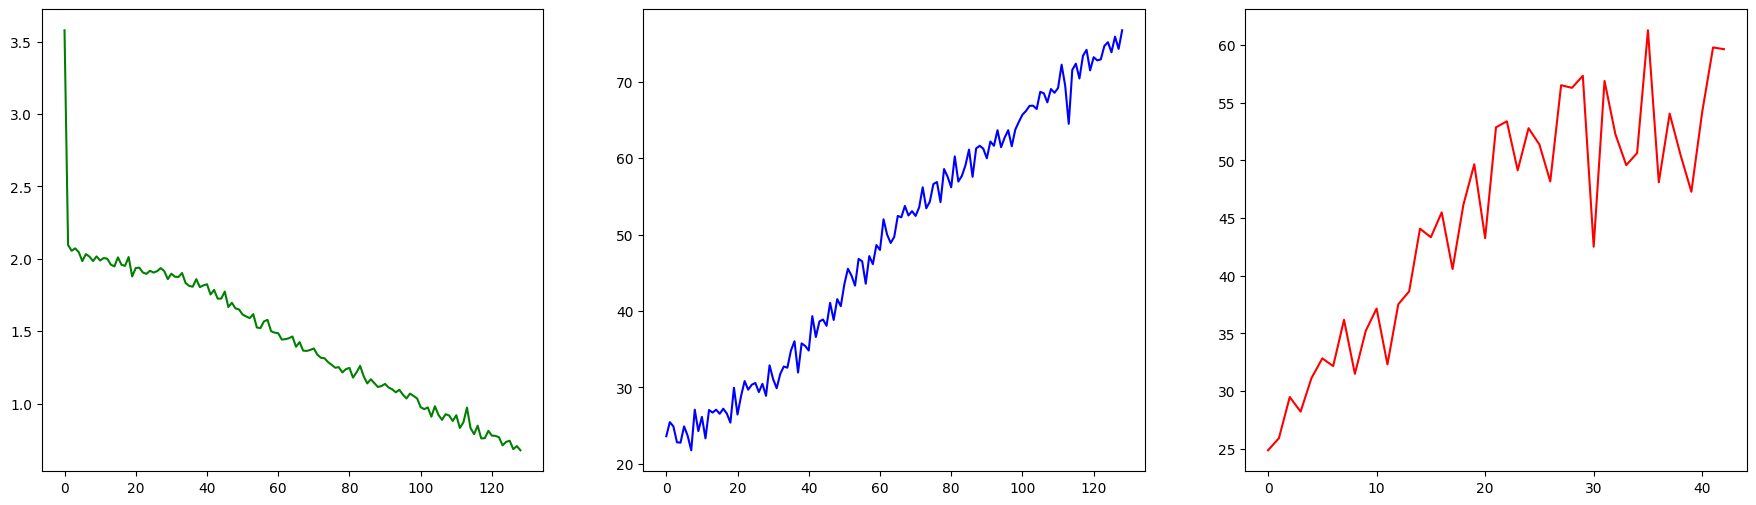

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(22, 6))
sns.lineplot(x=range(len(train_losses)), y=train_losses, color="green", ax=ax[0])
sns.lineplot(x=range(len(train_accuracies)), y=train_accuracies, color="blue", ax=ax[1])
sns.lineplot(x=range(len(test_accuracies)), y=test_accuracies, color="red", ax=ax[2])

Calculating probabilities:   0%|          | 0/42 [00:00<?, ?it/s]

Accuracy: 61.28%


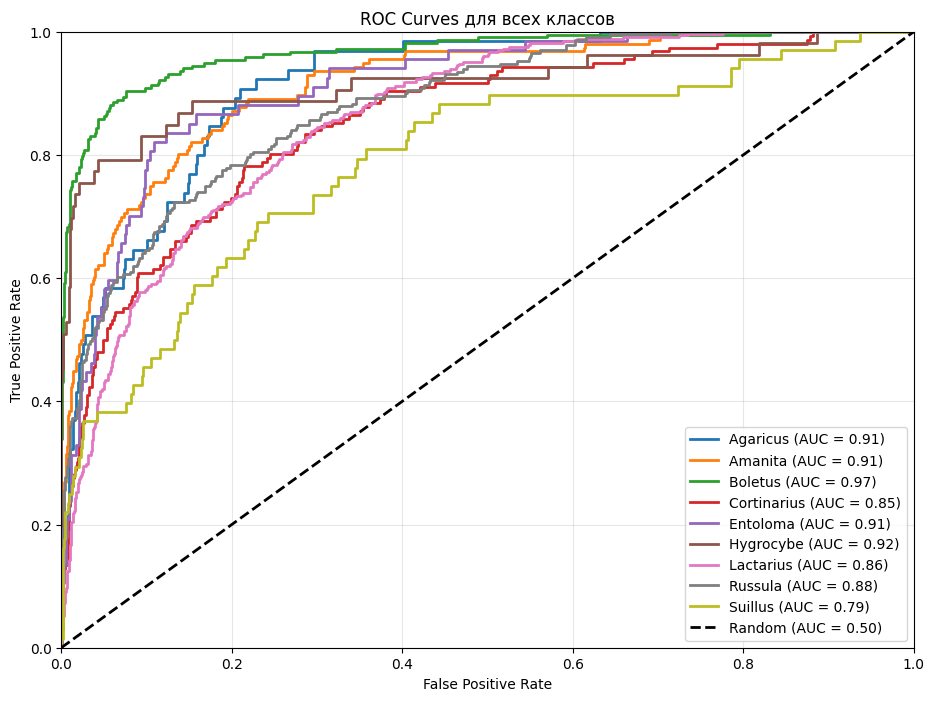

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model.load_state_dict(torch.load('best_alexnet_model.pth'))
model.eval()

test_correct = 0
test_total = 0
class_names = full_dataset.classes

all_probabilities = []
all_labels_roc = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Calculating probabilities"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        all_probabilities.extend(probabilities.cpu().numpy())
        all_labels_roc.extend(labels.cpu().numpy())

all_probabilities = np.array(all_probabilities)
all_labels_roc = np.array(all_labels_roc)

y_test_bin = label_binarize(all_labels_roc, classes=range(9))

plt.figure(figsize=(11, 8))

for i in range(9):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probabilities[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves для всех классов')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

test_acc = 100.0 * test_correct / test_total
print(f"Accuracy: {test_acc:.2f}%")